# 1.  <center>SENTIMENT SCORE PREDICTIONS - EXPLORATORY DATA ANALYSIS </center>

### Let's Explore the dataset to gain insight before proceeding to building Sentiment Analysis Model

### Import Libraries

In [534]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
import string
from sklearn.metrics import accuracy_score,mean_squared_error

In [596]:
# Read in csv dataset
df_train = pd.read_csv('NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv('NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

In [558]:
# Sample 5 rows
df_train.sample(5)

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
27,34211817,360098,And the apr,38,49,10.0
48860,34138144,236599,There is not just one.,0,21,10.0
36935,603801070,2387386,The easy application process and great custome...,0,56,10.0
3813,34162274,274157,Fast and easy,0,13,10.0
70270,699628036,4104103,Very high professional service,0,30,10.0


**Summary Statistic**

In [559]:
df_train.describe()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
count,5.664400e+04,5.664400e+04,56644.000000,56644.000000,56644.000000
mean,2.574779e+08,1.222144e+06,28.914007,69.882494,9.516718
std,2.863174e+08,1.291352e+06,80.051974,89.708530,1.236785
min,3.413701e+07,2.350060e+05,0.000000,1.000000,0.000000
25%,3.419668e+07,3.370468e+05,0.000000,24.000000,10.000000
50%,3.421431e+07,3.635095e+05,0.000000,43.000000,10.000000
75%,5.945210e+08,2.179805e+06,27.000000,81.000000,10.000000
max,7.255450e+08,4.522466e+06,2154.000000,2266.000000,10.000000


#### Interesting to see mean score at 9.5. Overall there has been positive sentiments on the services they received 95% of  the time.

### Inspecting rows and columns

In [579]:
def UniqueCount(df):
    """ 
    Takes in dataframe and return a unique count for each columns and shape
    """
    for col in df.columns:
        print(col, ':', df[col].nunique())
    print('Number of rows : {}\n Number of columns :{}'.format(df.shape[0],df.shape[1]))

In [580]:
UniqueCount(df_train)

DOCUMENT_ID : 39583
SENTENCE_ID : 56644
SENTENCE : 45027
SENTENCE_START_POS : 692
SENTENCE_END_POS : 751
SCORE : 11
Number of rows : 56644
 Number of columns :6


In [581]:
UniqueCount(df_validate)

DOCUMENT_ID : 9896
SENTENCE_ID : 14019
SENTENCE : 12018
SENTENCE_START_POS : 446
SENTENCE_END_POS : 518
SCORE : 11
Number of rows : 14019
 Number of columns :6


* There are `56,644` rows in train data and `14,019` in validation set. Out of that, there are `39,583` unique `DOCUMENT_ID` and `56,644` unique `SENTENCE_ID`. We will aggregate all sentences to their corresponding `DOCUMENT_ID`. The process will be done on validation data to ensure we feed in the right data format for inference.

*Lets pull `SENTENCE` that belong to a `DOCUMENT_ID.

In [561]:
df_train[df_train['DOCUMENT_ID'] == 584203035]['SENTENCE']

3                                                  Thanks!
5                  I paid off a best egg I had in the past
11719    I wish it would have been a little lower in in...
11722                                It was fast and easy.
11724       everything went extremely smoothly and quickly
11751                               this is my second loan
Name: SENTENCE, dtype: object

We can see from the above that all the six sentences belong to document id `584203035`.We need to find a way to map them while preserving its SCORE.

#### Check for na/null values

Wheww! 21 rows of `SENTENCE`  column are missing. We will take care of that during our join operations

In [526]:
df_train.isna().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [562]:
# Very Important to know the data type.
df_train.dtypes

DOCUMENT_ID             int64
SENTENCE_ID             int64
SENTENCE               object
SENTENCE_START_POS      int64
SENTENCE_END_POS        int64
SCORE                 float64
dtype: object

### Ploting Distribution of SCORE

Text(0.5, 1.0, 'SCORE DISTRIBUTION')

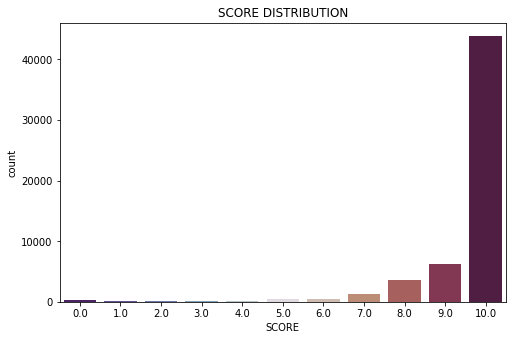

In [597]:
#plot class distribution
plt.rcParams['figure.figsize']=(8,5)
ax= sns.countplot(df_train.SCORE, palette='twilight_shifted')
ax.ticklabel_format(style='plain',axis='y')
plt.subplots_adjust(top=0.9)
plt.xlabel('SCORE')
plt.title('SCORE DISTRIBUTION')

As can be seen, most of the distributions are skewed Negatively. Chosing the right evaluation metric would be very important for training a model that generalizes well due to imbalanced label(SCORE).

### Preprocess the SENTENCE columns

In [582]:
stop = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

def clean_text(doc):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in str(doc) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word.lower() not in stop])
train_df['SENTENCE'] = train_df['SENTENCE'].apply(text_process)

In [583]:
# Apply the function to SENTENCE column as shown to tokenize and remove stopwords
train_df['SENTENCE'] = train_df['SENTENCE'].apply(lambda x:clean_text(x))
df_validate['SENTENCE'] = df_validate['SENTENCE'].apply(lambda x:clean_text(x))

### Join DOCUMENT_ID with SENTENCE

Here, we take care of all sentences and chain them to their corresponding `DOCUMENT_ID`. `SENTENCE_START_POS	SENTENCE_END_POS` are no longer needed going forward.

In [588]:
df_train = train_df.groupby(['DOCUMENT_ID','SCORE']).agg({'SENTENCE': ' '.join})
df_valid = df_validate.groupby(['DOCUMENT_ID','SCORE']).agg({'SENTENCE': ' '.join})

In [589]:
# Reset index and change the DOCUMENT_ID fron integer to STRING
df_train = df_train.reset_index()
df_valid = df_valid.reset_index()
df_train['DOCUMENT_ID'] = df_valid['DOCUMENT_ID'].astype(str)
df_valid['DOCUMENT_ID'] = df_valid['DOCUMENT_ID'].astype(str)

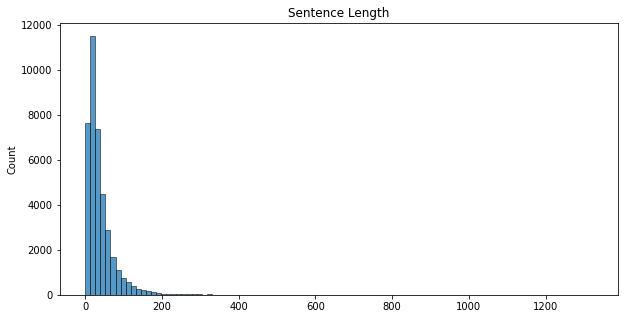

In [590]:
# visualize distibution of sentence Length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df_train.SENTENCE], bins=100)
plt.title('Sentence Length')
plt.show()

In [591]:
#find the maximum length
max_len = max([len(sent) for sent in df_train.SENTENCE])
print('Max length: ', max_len)

Max length:  1322


### WordCloud.
This gives us an idea about the most common words used in a sentences.

### Train Data

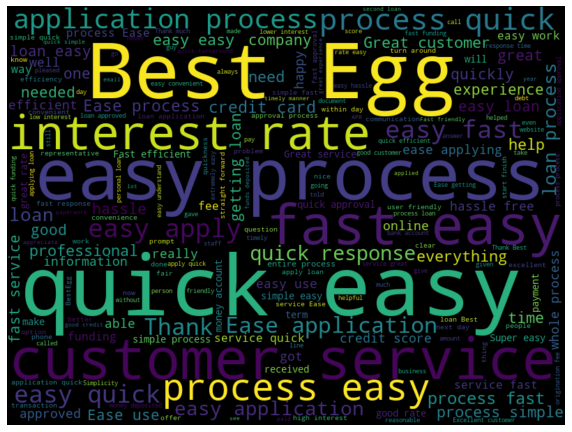

In [600]:
import wordcloud
train = ' '.join([str(text) for text in df_train['SENTENCE']])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(train)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Validation Data

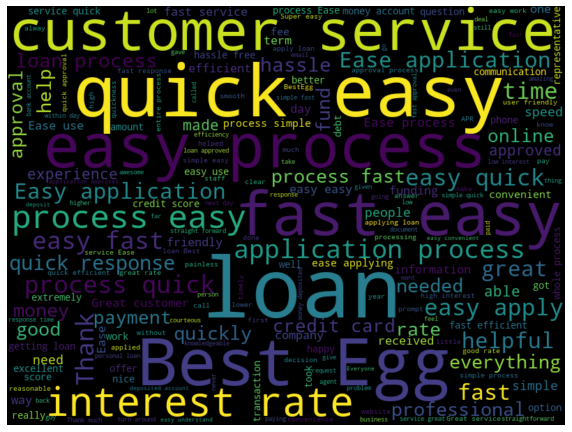

In [601]:
valid = ' '.join([str(text) for text in df_valid['SENTENCE']])
wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(valid)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Looks the customers are really happy with the serviices as some positive sentiments like `Quick, Easy process, customer service and of course Best Egg` are most frequently used in the documents. 

## .... NEXT, We Develop a Machiine Learning To Predict Sentiment Score